In [1]:
!nvidia-smi

Sun May  3 18:33:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install transformers

In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from string import digits
import re

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
PRE_TRAINED_MODEL = 'bert-base-uncased'
BATCH_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Special thanks to Venelin Valkov on Youtube for part of the code

# Max token length

In [ ]:
MAXLEN = 150

In [ ]:
attributes_df=pd.read_csv('attributes_df.csv')
style_df=pd.read_csv('style_df.csv')
#tagged_products_df=pd.read_csv('tagged_products_df.csv')

In [ ]:
cols = ['description','product_full_name']#, 'brand', 'name']
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [ ]:
def token_length(row, cols, tokenizer):
  token_len = 0
  for col in cols:
    token_len += len(tokenizer.encode(str(row[col]), max_length=512))
  return token_len

In [ ]:
token_lens = attributes_df.apply(lambda row: token_length(row, cols, tokenizer), axis=1)

***Here we can do something to see how to shrink the longer token len rows***

Text(0.5, 0, 'Token count')

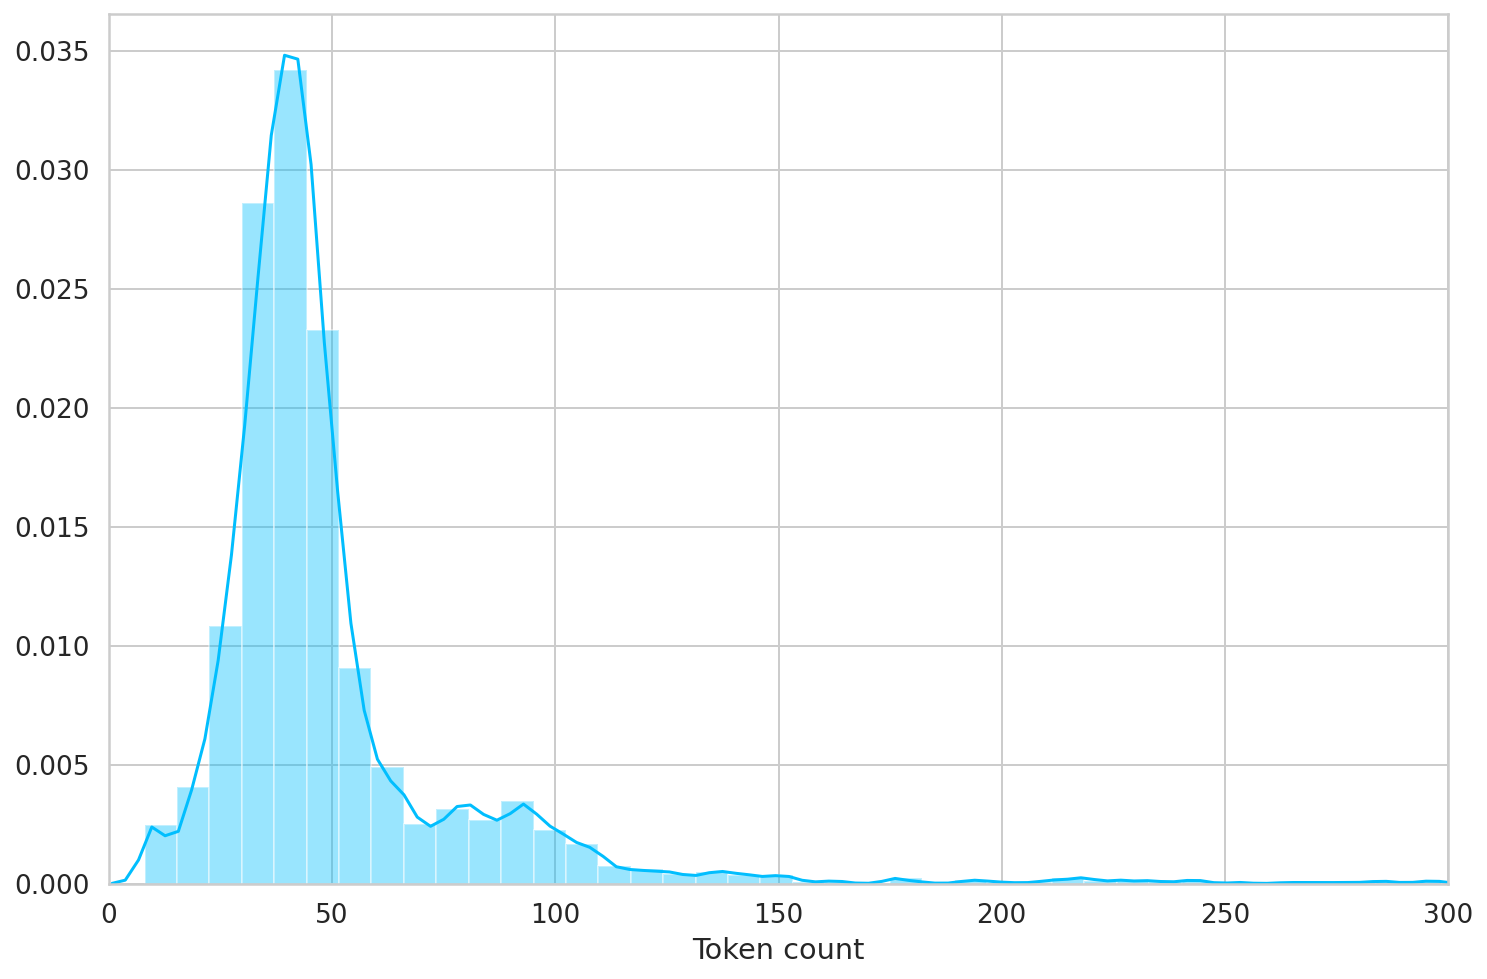

In [206]:
sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count')

# Bert models

In [ ]:
class BERTBaseUncasedCNN(nn.Module):
  def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
    super(BERTBaseUncased, self).__init__()
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)
    self.V = embed_num
    self.D = embed_dim
    self.C = class_num
    self.Co = kernel_num
    self.Ks = kernel_sizes
    self.static = static
    self.convs1 = nn.ModuleList([nn.Conv2d(1, self.Co, (K, self.D)) for K in self.Ks])
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(len(self.Ks) * self.Co + len(categories) + 1, self.C)

  def forward(self, input_ids, attention_mask, token_type_ids, brand, category):
    x, _ = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        token_type_ids=token_type_ids)
    if self.static:
      x = Variable(x)
    x = x.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
    x = torch.cat(x, 1)
    x = torch.cat((brand.view(-1,1),x),dim=1)
    x = torch.cat((category.view(-1,len(categories)),x),dim=1)
    x = self.dropout(x)
    x = x.view(-1, len(self.Ks) * self.Co + len(categories) + 1)
    return self.fc1(x)
  def resize_token_embeddings(self, tokenizer_len):
    self.bert.resize_token_embeddings(tokenizer_len)

In [ ]:
class BERTBaseUncased(nn.Module):
  def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
    super(BERTBaseUncased, self).__init__()
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)
    self.cat_len = len(categories)
    self.dropout = nn.Dropout(p=dropout)
    self.hidden1 = nn.Linear(self.bert.config.hidden_size + self.cat_len + 1, 64)
    self.hidden2 = nn.Linear(64, 16)
    self.out = nn.Linear(16, 1)

  def forward(self, input_ids, attention_mask, token_type_ids, brand, category):
    _, x = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        token_type_ids=token_type_ids)
    x = torch.cat((brand.view(-1,1),x),dim=1)
    x = torch.cat((category.view(-1,self.cat_len),x),dim=1)
    x = self.dropout(x)
    x = x.view(-1, self.bert.config.hidden_size + self.cat_len + 1)
    x = self.hidden1(x)
    x = self.hidden2(x)
    return self.out(x)
  def resize_token_embeddings(self, tokenizer_len):
    self.bert.resize_token_embeddings(tokenizer_len)

In [ ]:
class Clothberta(nn.Module):
  def __init__(self, dropout):
    super(Clothberta, self).__init__()
    self.roberta = transformers.RobertaModel.from_pretrained('/content/weights/')
    self.cat_len = len(categories)
    self.dropout = nn.Dropout(p=dropout)
    self.hidden1 = nn.Linear(self.roberta.config.hidden_size + self.cat_len + 1, 64)
    self.hidden2 = nn.Linear(64, 16)
    self.out = nn.Linear(16, 1)

  def forward(self, input_ids, attention_mask, brand, category):
    _, x = self.roberta(
        input_ids=input_ids, 
        attention_mask=attention_mask)
    x = torch.cat((brand.view(-1,1),x),dim=1)
    x = torch.cat((category.view(-1,self.cat_len),x),dim=1)
    x = self.dropout(x)
    x = x.view(-1, self.roberta.config.hidden_size + self.cat_len + 1)
    x = self.hidden1(x)
    x = self.hidden2(x)
    return self.out(x)
  def resize_token_embeddings(self, tokenizer_len):
    self.roberta.resize_token_embeddings(tokenizer_len)

In [ ]:
class StyleDataLoader:
  def __init__(self, item_desc, brand, brand_category, name, targets, tokenizer, max_length):
    self.item_desc = item_desc
    self.brand = brand
    self.brand_category = brand_category
    self.name = name
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.targets = targets
  
  def __len__(self):
    return len(self.item_desc)
    
  def __getitem__(self, item):
    item_description = str(self.item_desc[item])
    item_brand = self.brand[item]
    item_brand_category = self.brand_category[item]
    item_name = str(self.name[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        item_description, item_name,
        max_length=self.max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        #'token_type_ids': encoding['token_type_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long),
        'brand':torch.tensor(item_brand, dtype=torch.float),
        'brand_category':torch.tensor(item_brand_category, dtype=torch.float)
    }

In [ ]:
#tokenizer = transformers.RobertaTokenizer.from_pretrained('/content/weights/',max_len=MAXLEN)

In [ ]:
df_train, df_val = train_test_split(attributes_df, stratify=attributes_df.weekend_target,random_state=RANDOM_SEED, test_size=0.1)
df_val, df_test = train_test_split(df_val, stratify=df_val.weekend_target,random_state=RANDOM_SEED, test_size=0.5)

In [288]:
df_train.shape, df_val.shape, df_test.shape

((3276, 188), (182, 188), (183, 188))

In [ ]:
categories = df_train.iloc[:,11:-1].columns.tolist()

In [ ]:
def create_data_loader(df, target, tokenizer, max_len, batch_size, categories, weighted_sampler=None):
  dataset = StyleDataLoader(item_desc=df.description.to_numpy(),
                brand=df.brand_le.to_numpy(),
                brand_category=df[categories].to_numpy(),
                name=df.product_full_name.to_numpy(),
                targets=df[target].to_numpy().reshape(-1,1),
                tokenizer=tokenizer,
                max_length=MAXLEN)
  return DataLoader(
      dataset,
      sampler=weighted_sampler,
      batch_size=batch_size)

In [ ]:
class_weights = 1 / df_train['weekend_target'].value_counts()
class_index = df_train['weekend_target'].value_counts().index
weights_map = {class_index[i]:class_weights.iloc[i] for i in range(len(class_index))}
class_weights_all = df_train['weekend_target'].map(weights_map).tolist()

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [ ]:
train_data_loader = create_data_loader(df_train, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories)#, weighted_sampler=weighted_sampler)
val_data_loader = create_data_loader(df_val, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories)
test_data_loader = create_data_loader(df_test, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories)

In [ ]:
embed_num = MAXLEN
embed_dim = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL).config.hidden_size
class_num = 1
kernel_num = 3
kernel_sizes = [2,3,4]
dropout = 0.3
static = True
weekendmodel = BERTBaseUncased(
    embed_num=embed_num, 
    embed_dim=embed_dim, 
    class_num=class_num, 
    kernel_num=kernel_num, 
    kernel_sizes=kernel_sizes, 
    dropout=dropout, 
    static=static)
weekendmodel = weekendmodel.to(device)

In [ ]:
# num_added_toks = tokenizer.add_tokens(['CATEGORY_TOKEN', 'NAME_TOKEN'])
# weekendmodel.resize_token_embeddings(len(tokenizer))

In [ ]:
EPOCHS = 20
optimizer = AdamW(weekendmodel.parameters(),
          lr=2e-5,
          correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

loss_fn = nn.BCEWithLogitsLoss().to(device)

In [ ]:
def get_accuracy(y_true, y_pred):
  return (y_true == y_pred).sum().float() / len(y_true)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, 
        device, scheduler, n_examples):
  model = model.train()
  
  losses = []
  corrected_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    #token_type_ids = d['token_type_ids'].to(device)
    targets = d['targets'].to(device)
    brand = d['brand'].to(device)
    brand_category = d['brand_category'].to(device)

    outputs = model(
      input_ids=input_ids,
      #token_type_ids=token_type_ids,
      attention_mask=attention_mask,
      brand=brand,
      category=brand_category
    )


    preds = torch.sigmoid(outputs).ge(0.5).view(-1)#torch.squeeze(torch.sigmoid(outputs))
    loss = loss_fn(outputs, targets.type_as(outputs))

    corrected_predictions += get_accuracy(targets, preds)
    losses.append(loss.item())

    loss.backward()
    # clipping grads for to prevent exploding grad
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return corrected_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      #token_type_ids = d['token_type_ids'].to(device)
      targets = d['targets'].to(device)
      brand = d['brand'].to(device)
      brand_category = d['brand_category'].to(device)

      outputs = model(
        input_ids=input_ids,
        #token_type_ids=token_type_ids,
        attention_mask=attention_mask,
        brand=brand,
        category=brand_category
      )
      preds = torch.sigmoid(outputs).ge(0.5).view(-1)#torch.squeeze(torch.sigmoid(outputs))
      loss = loss_fn(outputs, targets.type_as(outputs))

      correct_predictions += get_accuracy(targets, preds)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def train(model):
  %%time

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(weekendmodel.state_dict(), 'weekend_model_state.bin')
      best_accuracy = val_acc

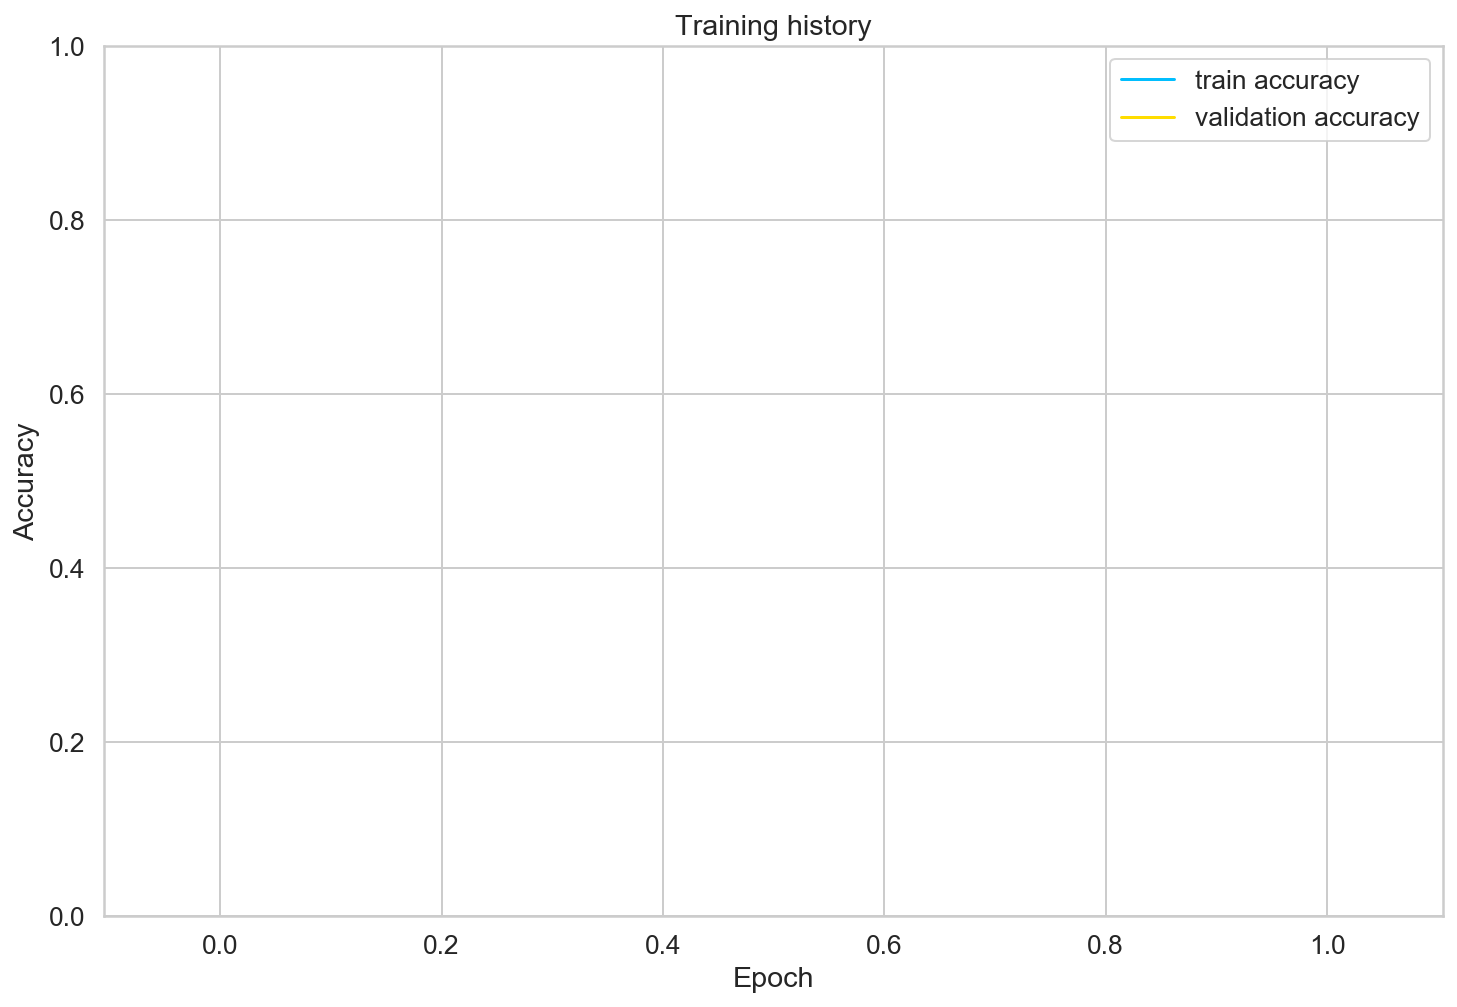

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  weekendmodel,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      token_type_ids = d['token_type_ids'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )

      probs = torch.sigmoid(outputs)
      preds = probs.ge(0.5).view(-1)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  weekendmodel,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['1','0']))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Weekend')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['1','0'], columns=['1','0'])
show_confusion_matrix(df_cm)